In [104]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import time

In [105]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)) # flattens the data
])

In [133]:
batch_size = 512

trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transforms)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transforms)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [134]:
trainset[0][0].shape

torch.Size([784])

In [135]:
# No. of samples in trainset
len(trainloader) * batch_size

60416

In [136]:
# No. of samples in testset
len(testloader) * batch_size

10240

In [137]:
class SoftmaxReg(nn.Module):
    def __init__(self, x_dim,hidden_dim,y_dim):
        super(SoftmaxReg,self).__init__()
        self.linear1 = nn.Linear(x_dim,hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim,y_dim)
    def forward(self,X):
        X = self.linear1(X)
        X = self.relu(X)
        X = self.linear2(X)
        return X

In [138]:
def train_model(model, trainloader, device, epochs, lr):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for xi, yi in trainloader:
            xi, yi = xi.to(device), yi.to(device)
            output = model(xi)
            loss = criterion(output, yi)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(trainloader)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')
    return losses


In [139]:
def test_model(model, testloader, device):
    model.eval()
    y_pred = np.array([])
    y_true = np.array([])
    with torch.no_grad():
        for xi, yi in testloader:
            xi,yi = xi.to(device), yi.to(device)
            output = model(xi)
            _,y_pred_tensor = torch.max(output,1)
            y_pred = np.hstack((y_pred,y_pred_tensor.cpu().numpy()))
            y_true = np.hstack((y_true,yi.cpu().numpy()))
    return (classification_report(y_pred=y_pred,y_true=y_true))

In [140]:
torch.get_default_device()

device(type='cpu')

In [144]:
x_dim = trainset[0][0].shape[0]
y_dim = 10
hidden_dim = 512
epochs = 30
lr = 0.001
train_time_gpu = 0
test_time_gpu = 0
train_time_cpu = 0
test_time_cpu = 0

In [145]:
device = torch.device('cpu')

In [146]:
modelOnCPU = SoftmaxReg(x_dim,hidden_dim,y_dim)
start = time.time()
losses2 = train_model(modelOnCPU,trainloader,device,epochs,lr)
end = time.time()
train_time_cpu = end - start
print("Training Time: ",train_time_cpu)

Epoch 1/30, Loss: 2.290090332596989
Epoch 2/30, Loss: 2.261552851078874
Epoch 3/30, Loss: 2.2331668946702603
Epoch 4/30, Loss: 2.2049347808805564
Epoch 5/30, Loss: 2.1761147450592557
Epoch 6/30, Loss: 2.1464892484373967
Epoch 7/30, Loss: 2.116098201881021
Epoch 8/30, Loss: 2.0845363625025346
Epoch 9/30, Loss: 2.0517754090034357
Epoch 10/30, Loss: 2.0176795266442378
Epoch 11/30, Loss: 1.9824785297199832
Epoch 12/30, Loss: 1.9460439257702584
Epoch 13/30, Loss: 1.9083290140507585
Epoch 14/30, Loss: 1.8700515122736914
Epoch 15/30, Loss: 1.8301323914931993
Epoch 16/30, Loss: 1.789516857114889
Epoch 17/30, Loss: 1.7489651663828705
Epoch 18/30, Loss: 1.7069324345911963
Epoch 19/30, Loss: 1.6648943525249675
Epoch 20/30, Loss: 1.6225956890542628
Epoch 21/30, Loss: 1.5804480182922493
Epoch 22/30, Loss: 1.5392572607024242
Epoch 23/30, Loss: 1.498210090701863
Epoch 24/30, Loss: 1.4581078594013797
Epoch 25/30, Loss: 1.417989894495172
Epoch 26/30, Loss: 1.3790308287588215
Epoch 27/30, Loss: 1.342151

In [147]:
print("CLASSIFICATION REPORT FOR MODEL TRAINED ON CPU")
start = time.time()
report_cpu = test_model(modelOnCPU,testloader,device)
end = time.time()
test_time_cpu = end - start
print(report_cpu)
print("Testing Time: ",test_time_cpu)

CLASSIFICATION REPORT FOR MODEL TRAINED ON CPU
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89       980
         1.0       0.78      0.97      0.86      1135
         2.0       0.87      0.76      0.81      1032
         3.0       0.68      0.88      0.77      1010
         4.0       0.84      0.81      0.82       982
         5.0       0.94      0.38      0.54       892
         6.0       0.82      0.90      0.86       958
         7.0       0.84      0.87      0.85      1028
         8.0       0.78      0.70      0.74       974
         9.0       0.80      0.75      0.77      1009

    accuracy                           0.80     10000
   macro avg       0.82      0.80      0.79     10000
weighted avg       0.82      0.80      0.79     10000

Testing Time:  1.1664602756500244


In [148]:
device = torch.device('cuda')
torch.cuda.get_device_name(0)

'Tesla T4'

In [149]:
modelOnGPU = SoftmaxReg(x_dim,hidden_dim,y_dim)
start = time.time()
losses1 = train_model(modelOnGPU,trainloader,device,epochs,lr)
end = time.time()
train_time_gpu = end - start
print("Training Time: ",train_time_gpu)

Epoch 1/30, Loss: 2.282423290155702
Epoch 2/30, Loss: 2.2552043906712935
Epoch 3/30, Loss: 2.227971875061423
Epoch 4/30, Loss: 2.2004024982452393
Epoch 5/30, Loss: 2.1722303891586043
Epoch 6/30, Loss: 2.1431534492363364
Epoch 7/30, Loss: 2.1129563966039884
Epoch 8/30, Loss: 2.0813021478006397
Epoch 9/30, Loss: 2.0485307160070385
Epoch 10/30, Loss: 2.0143432869749556
Epoch 11/30, Loss: 1.9792044556747048
Epoch 12/30, Loss: 1.9421035334215326
Epoch 13/30, Loss: 1.9036995455370112
Epoch 14/30, Loss: 1.8643511786299236
Epoch 15/30, Loss: 1.8237993212069494
Epoch 16/30, Loss: 1.7821337348323758
Epoch 17/30, Loss: 1.7405680781703885
Epoch 18/30, Loss: 1.69799532223556
Epoch 19/30, Loss: 1.6557326306731015
Epoch 20/30, Loss: 1.6130362486435195
Epoch 21/30, Loss: 1.570487991227942
Epoch 22/30, Loss: 1.5282834131838912
Epoch 23/30, Loss: 1.4864497699980008
Epoch 24/30, Loss: 1.4466146998486276
Epoch 25/30, Loss: 1.4063223135673393
Epoch 26/30, Loss: 1.3680662522881717
Epoch 27/30, Loss: 1.33044

In [150]:
print("CLASSIFICATION REPORT FOR MODEL TRAINED ON GPU")
start = time.time()
report_gpu = test_model(modelOnGPU,testloader,device)
end = time.time()
test_time_gpu = end - start
print(report_gpu)
print("Testing Time: ",test_time_gpu)

CLASSIFICATION REPORT FOR MODEL TRAINED ON GPU
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89       980
         1.0       0.78      0.97      0.86      1135
         2.0       0.86      0.76      0.81      1032
         3.0       0.67      0.87      0.76      1010
         4.0       0.82      0.80      0.81       982
         5.0       0.95      0.33      0.48       892
         6.0       0.83      0.91      0.87       958
         7.0       0.83      0.86      0.84      1028
         8.0       0.79      0.73      0.76       974
         9.0       0.78      0.76      0.77      1009

    accuracy                           0.80     10000
   macro avg       0.82      0.79      0.79     10000
weighted avg       0.81      0.80      0.79     10000

Testing Time:  1.1288127899169922


Text(0, 0.5, 'Loss')

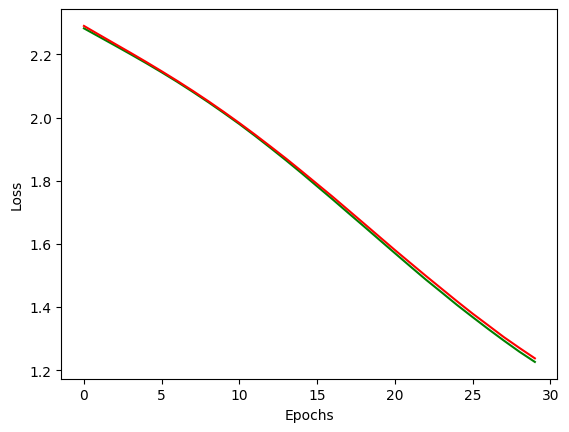

In [151]:
plt.plot(range(epochs),losses1,label = 'with GPU',c='g')
plt.plot(range(epochs),losses2,label = 'with CPU',c='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Training Time Comparison: CPU vs GPU')

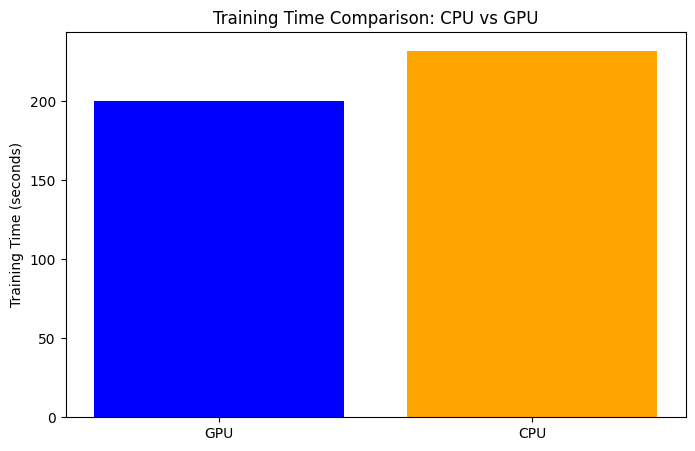

In [152]:
plt.figure(figsize=(8, 5))
plt.bar(['GPU','CPU'], [train_time_gpu,train_time_cpu], color=['blue', 'orange'])
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison: CPU vs GPU")

Text(0.5, 1.0, 'Testing Time Comparison: CPU vs GPU')

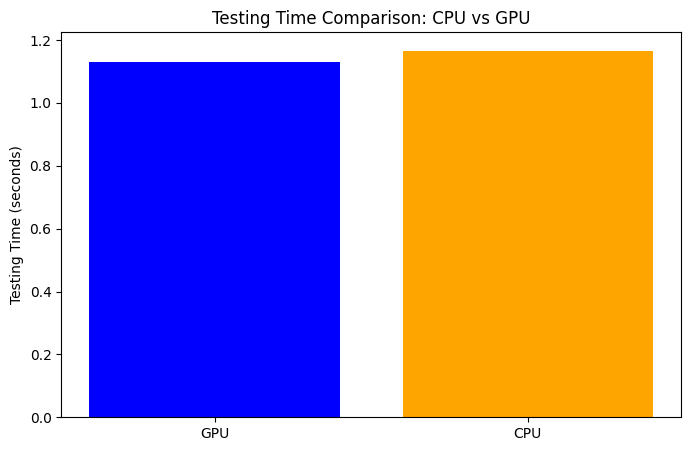

In [153]:
plt.figure(figsize=(8, 5))
plt.bar(['GPU','CPU'], [test_time_gpu,test_time_cpu], color=['blue', 'orange'])
plt.ylabel("Testing Time (seconds)")
plt.title("Testing Time Comparison: CPU vs GPU")